In [1]:
#rdkit関連のimport
from rdkit import Chem
from rdkit.Chem import PandasTools

#randamforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#その他のimport
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#sampleデータの読み込み
sample = pd.read_csv("../AmesCalculation/test/TestAmes_100samples.csv")

#データの規格化
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features
norm_datasets = sample.loc[:,['ID','smiles','activity']]
columns = sample.columns
for column in columns[3:]:
    norm_datasets[column] = rescaling(sample[column])

PandasTools.AddMoleculeColumnToFrame(frame=norm_datasets, smilesCol = 'smiles')

#pandasのデータフレームに分子を読み込み
original = pd.read_csv( '../AmesCalculation/AvailableAmesDataSets.csv')

#fingerprint
rdkit_fp = []
for mol in norm_datasets.ROMol:
    mol = Chem.AddHs(mol) 
    fp = [x for x in Chem.RDKFingerprint(mol)]
    rdkit_fp.append(fp)
    
calc_datasets = norm_datasets.iloc[:,3:-1]
rdkit_fp_df = pd.DataFrame(rdkit_fp)
calc_sets = pd.concat([calc_datasets,rdkit_fp_df], axis=1)

In [ ]:
"""
X_train: 訓練データ
X_test: テストデータ
y_train: 訓練データの正解ラベル
y_test: テストデータの正解ラベル
"""

In [2]:
#分類するデータの確認
norm_datasets['activity'].value_counts()

1.0    52
0.0    48
Name: activity, dtype: int64

In [3]:
#Only Rdkit Finger Print
X_train, X_test, y_train, y_test = train_test_split(rdkit_fp_df, norm_datasets.activity, random_state=0)#test_size=0.25(default)
forest = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test) #予測値算出
print('=======Only Rdkit Finger Print========')
print('train accuracy: {:.3f}'.format(forest.score(X_train, y_train)))
print('test accuracy: {:.3f}'.format(forest.score(X_test, y_test)))
print('accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#Calculation Results + Rdkit Finger Print
X2_train, X2_test, y2_train, y2_test = train_test_split(calc_sets, norm_datasets.activity, random_state=0)
forest2 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest2.fit(X2_train, y2_train)
y2_pred = forest2.predict(X2_test) #予測値算出
print('=======Calculation Results + Rdkit Finger Print========')
print('train accuracy: {:.3f}'.format(forest2.score(X2_train, y2_train)))
print('test accuracy: {:.3f}'.format(forest2.score(X2_test, y2_test)))
print('accuracy: {:.3f}'.format(accuracy_score(y2_test, y2_pred)))
#Only Calculation Results
X3_train, X3_test, y3_train, y3_test = train_test_split(calc_datasets, norm_datasets.activity, random_state=0)
forest3 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest3.fit(X3_train, y3_train)
y3_pred = forest3.predict(X3_test) #予測値算出
print('=======Only Calculation Results========')
print('train accuracy: {:.3f}'.format(forest3.score(X3_train, y3_train)))
print('test accuracy: {:.3f}'.format(forest3.score(X3_test, y3_test)))
print('accuracy: {:.3f}'.format(accuracy_score(y3_test, y3_pred)))

=======Only Rdkit Finger Print========
train accuracy: 1.000
test accuracy: 0.520
accuracy: 0.520
=======Calculation Results + Rdkit Finger Print========
train accuracy: 1.000
test accuracy: 0.520
accuracy: 0.520
=======Only Calculation Results========
train accuracy: 1.000
test accuracy: 0.600
accuracy: 0.600


In [4]:
#activityごとの評価
print('=======Only Rdkit Finger Print========')
print(classification_report(y_test,y_pred))
print('=======Calculation Results + Rdkit Finger Print========')
print(classification_report(y2_test,y2_pred))
print('=======Only Calculation Results========')
print(classification_report(y3_test,y3_pred))

=======Only Rdkit Finger Print========
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54        13
         1.0       0.50      0.50      0.50        12

    accuracy                           0.52        25
   macro avg       0.52      0.52      0.52        25
weighted avg       0.52      0.52      0.52        25

=======Calculation Results + Rdkit Finger Print========
              precision    recall  f1-score   support

         0.0       0.55      0.46      0.50        13
         1.0       0.50      0.58      0.54        12

    accuracy                           0.52        25
   macro avg       0.52      0.52      0.52        25
weighted avg       0.52      0.52      0.52        25

=======Only Calculation Results========
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        13
         1.0       0.58      0.58      0.58        12

    accuracy                           0.60    

Text(91.68, 0.5, 'true value')

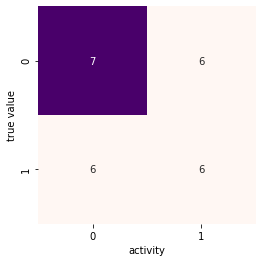

In [5]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('activity')
plt.ylabel('true value')

In [6]:
# Feature Importance
fti = forest.feature_importances_  
fti2 = forest2.feature_importances_  
fti3 = forest3.feature_importances_  
calc_index = columns[3:]
fti_df = pd.DataFrame(fti, columns = ['importance'])
fti2_index = list(calc_index)+list(fti_df.index)
fti3_index = list(calc_index)
fti2_df = pd.DataFrame(fti2, columns =  ['importance'], index = fti2_index)
fti3_df = pd.DataFrame(fti3, columns =  ['importance'], index = fti3_index)
#sort
fti_df = fti_df.sort_values("importance", ascending=False)
fti2_df = fti2_df.sort_values("importance", ascending=False)
fti3_df = fti3_df.sort_values("importance", ascending=False)

=======Only Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

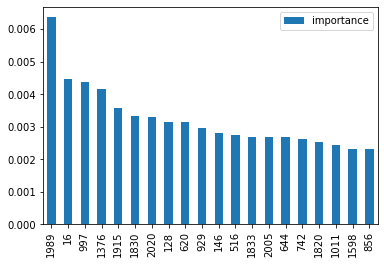

In [8]:
print('=======Only Rdkit Finger Print========')
plt.figure()
fti_df[:20].plot.bar() #Top20

=======Calculation Results + Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

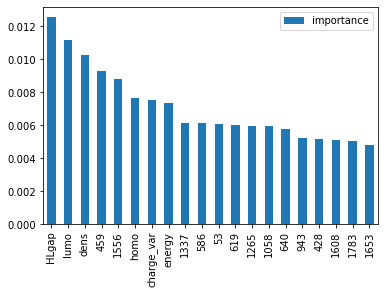

In [24]:
print('=======Calculation Results + Rdkit Finger Print========')
plt.figure()
fti2_df[:20].plot.bar() #Top20

=======Only Calculation Results========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

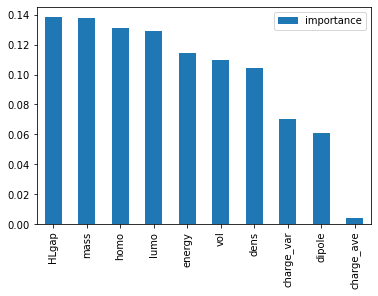

In [25]:
print('=======Only Calculation Results========')
plt.figure()
fti3_df.plot.bar()

In [9]:
#木の数でプロット
tree_num = range(1,500)
training_acc1 = []
test_acc1 =[]
training_acc2 = []
test_acc2 =[]
training_acc3 = []
test_acc3 = []
for N in tree_num:
    nforest1 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest2 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest3 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest1.fit(X_train, y_train)
    nforest2.fit(X2_train, y2_train)
    nforest3.fit(X3_train, y3_train)
    training_acc1.append(nforest1.score(X_train, y_train))
    test_acc1.append(nforest1.score(X_test, y_test))
    training_acc2.append(nforest2.score(X2_train, y2_train))
    test_acc2.append(nforest2.score(X2_test, y2_test))
    training_acc3.append(nforest3.score(X3_train, y3_train))
    test_acc3.append(nforest3.score(X3_test, y3_test))

In [1]:
#graph化
fig = plt.figure(figsize=(15.0,5.0))

#Only Rdkit Finger Print
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(tree_num, training_acc1, label = 'train')
ax1.plot(tree_num, test_acc1, label = 'test')
ax1.set_title('Only Rdkit Finger Print')

#Calculation Results + Rdkit Finger Print
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(tree_num, training_acc2, label = 'train')
ax2.plot(tree_num, test_acc2, label = 'test')
ax2.set_title('Calculation Results + Rdkit Finger Print')

#Only Calculation Results
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(tree_num, training_acc3, label = 'train')
ax3.plot(tree_num, test_acc3, label = 'test')
ax3.set_title('Only Calculation Results')

# 軸の一覧取得
axs = plt.gcf().get_axes()

# 軸毎にループ
for ax in axs:
    # 現在の軸を変更
    plt.axes(ax)
    
    # 凡例を表示
    plt.legend(loc=5)

    # グリッド
    plt.grid(linestyle='--')

    # 軸ラベル
    plt.xlabel('tree_num')
    plt.ylabel('accuracy')
    
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined